In [1]:
from rdkit import Chem
import pandas as pd
from rdkit.Chem import PandasTools

from IPython.display import HTML
def show_df(df):
    return HTML(df.to_html(notebook=True))

# Import Moonshot file

In [2]:
moonshot_file = "../../covid_submissions_all_info.csv"
df = pd.read_csv(moonshot_file)
PandasTools.AddMoleculeColumnToFrame(df,'SMILES','Molecule')

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
[18:04:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:04:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:04

# Murcko

In [3]:
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdchem

def GetTrueScaffold(mol,generic=False):
    #Not sure if hybridisation of dummy atom is correct
    #Not sure on properties
    #Seems to work as desired
    """
    Takes RDKit mol object
    Returns mol object of the murcko scaffold with original algorithm
    Stereochemistry is lost
    """
    mol = MurckoScaffold.GetScaffoldForMol(mol)
    atom_to_remove = []
    atom_to_clean = []
    
    for a in mol.GetAtoms():
        #Remove chirality
        mol.GetAtomWithIdx(a.GetIdx()).SetChiralTag(Chem.ChiralType.CHI_UNSPECIFIED)
        
        #For atoms bonded to only one other atom, these must be removed
        if len(a.GetBonds()) == 1:
            #Get index of atom to delete and append to deletion list
            atom_to_remove.append(a.GetIdx())

    #If there are atoms to delte
    if len(atom_to_remove) > 0:
        #Create an editable molecule (now RW)
        emol = rdchem.RWMol(mol)
        #Every time an atom is delted the index changes
        #Deletion list must be reversed to avoid rogue deletions
        for a in atom_to_remove[::-1]:
            #Remove atom by index a
            emol.RemoveAtom(a)
    #If the molecule is already the correct murcko scaffold set emol = mol
    else:
        emol = mol
    
    #This line used to cause errors
    #SanitizeMol(emol) often failed due to aromaticity
    #Attempts to solve this included replacing previously bonded atoms with the
    #wild card *
    #It seems clearing aromatic flags solved the issue
    try:
        #Clearing aromatic flags seems to fix everything
        Chem.Kekulize(emol,clearAromaticFlags=True)
        Chem.SanitizeMol(emol)
    except:
        #Error
        #Will show the input molecule and attempted editted molecule (before sanitization attempt)
        display("Input Mol")
        display(mol)
        display("Output Emol")
        display(emol)
        raise ("Error in santisation of new molecule")
        return False
    
    #The above procedure will remove all remaining decorating groups on scaffold
    #In some cases (like sulfonyl) this will leave an aliphatic chain
    #Additional application of MurckoScaffold algorithm is needed
    #However the RDKit implementation is sufficient 
    emol = MurckoScaffold.GetScaffoldForMol(emol)
    
    #If the generic scaffold is desired (Flag), make generic
    if generic:
        emol = MurckoScaffold.MakeScaffoldGeneric(emol)

    #Return the molecule
    return emol

In [4]:
#Use a smaller dataframe without all the excess data
#Just take CID (name) and molecule object
mol_df = df[["CID", "Molecule"]]

In [5]:
#Apply murcko algorithm and create new column with the full and generic scaffolds

mol_df["TrueMurcko"] = df.apply(lambda x: GetTrueScaffold(x["Molecule"]), axis = 1)
mol_df["TrueMurckoGeneric"] = df.apply(lambda x: GetTrueScaffold(x["Molecule"],generic=True), axis = 1)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,CID,Molecule,TrueMurcko,TrueMurckoGeneric
0,ANT-DIA-3c79be55-1,,,
1,ANT-DIA-3c79be55-2,,,
2,ANT-DIA-3c79be55-3,,,
3,ANT-DIA-3c79be55-4,,,
4,ANT-DIA-3c79be55-5,,,
5,ROB-UNI-b2e39629-1,,,
6,ROB-UNI-b2e39629-2,,,
7,ROB-UNI-b2e39629-3,,,
8,ROB-UNI-b2e39629-4,,,
9,ROB-UNI-b2e39629-5,,,

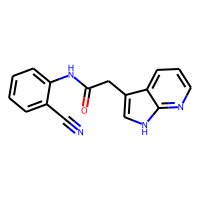
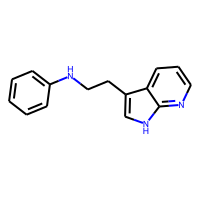
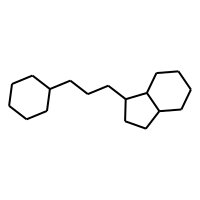
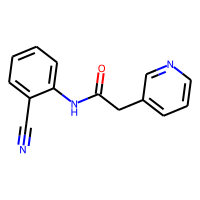
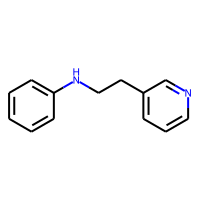
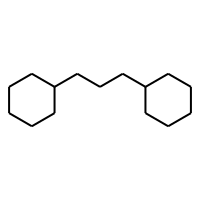
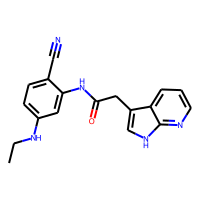
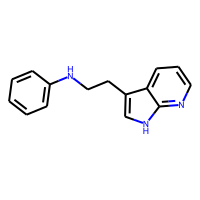
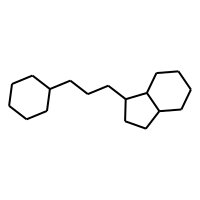
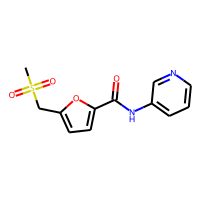
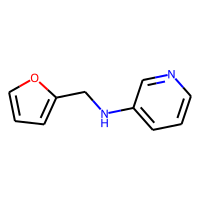
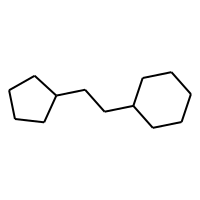
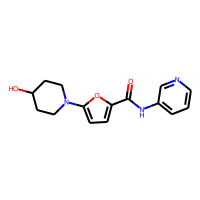
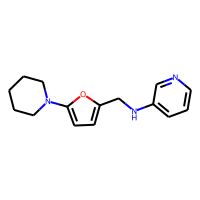
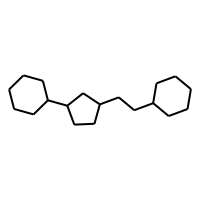
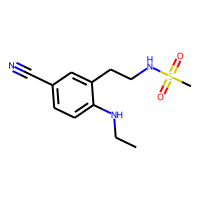
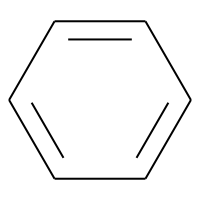
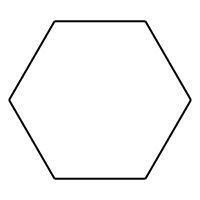
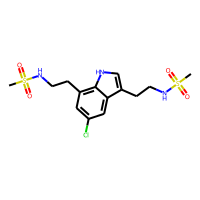
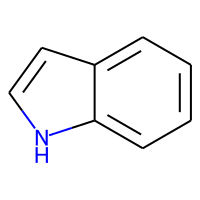
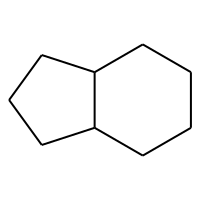
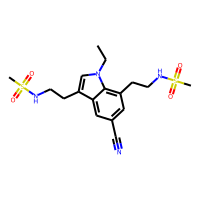
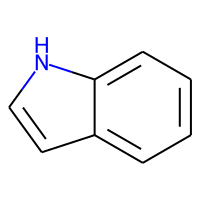
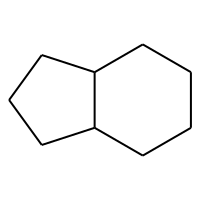
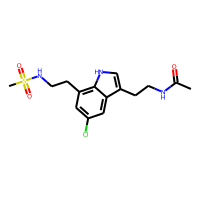
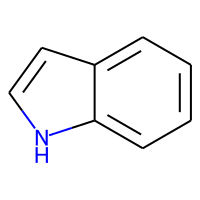
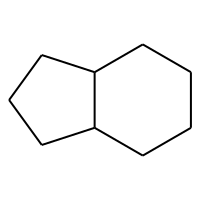
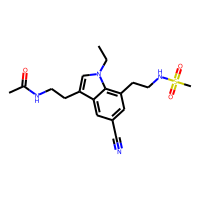
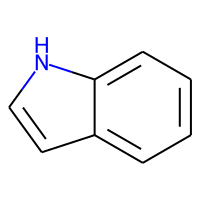
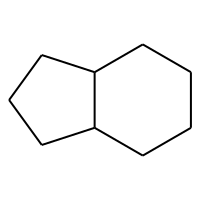
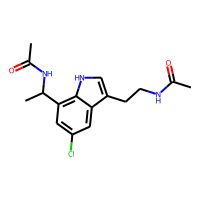
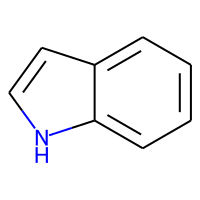
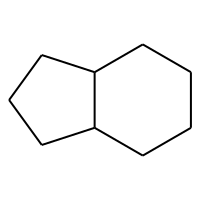
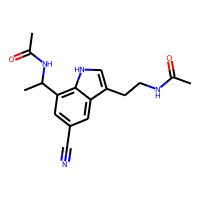
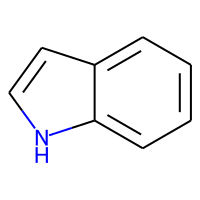
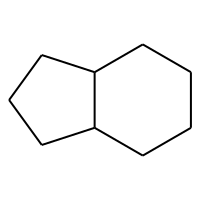
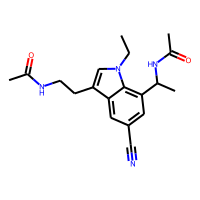
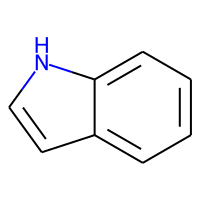
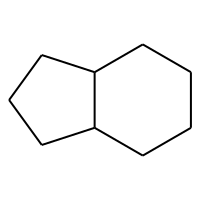
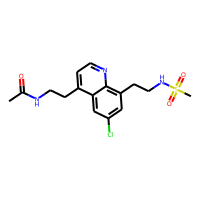
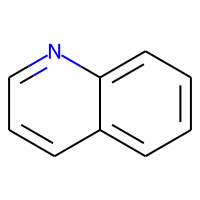
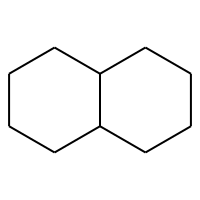
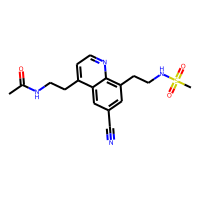
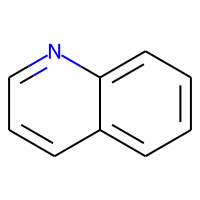
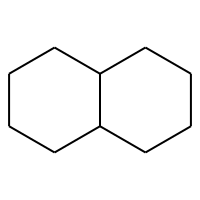
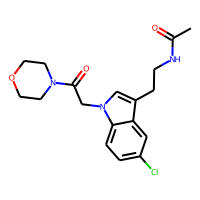
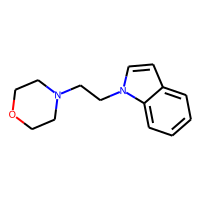
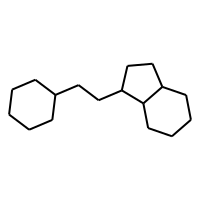
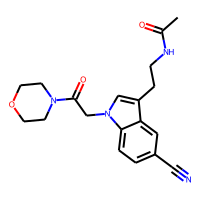
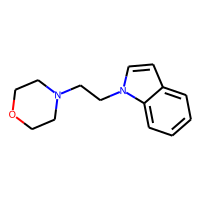
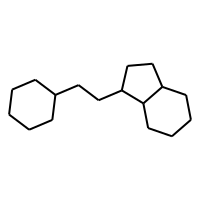
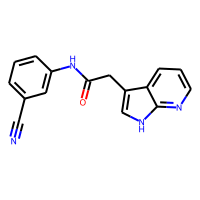
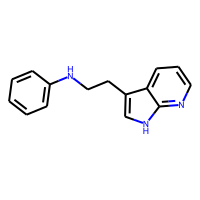
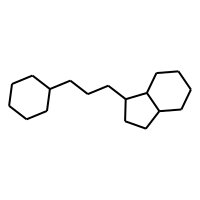
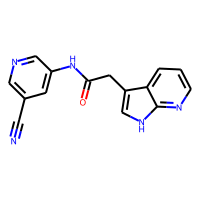
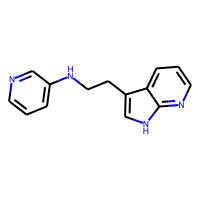
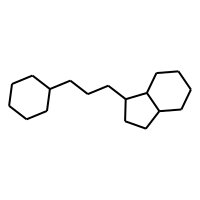
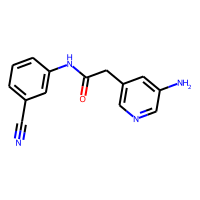
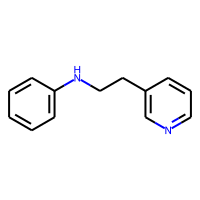
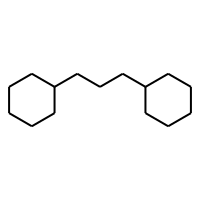

In [6]:
#comparison of diffrent murcko scaffolds
show_df(mol_df.head(20))

# Exploration

In [7]:
from rdkit import Chem
from rdkit.Chem import rdMolHash
import rdkit

# Considering the Murcko Scaffold (with atom identity)

In [8]:
#Take hash of scaffold
mol_df["mHash"] = mol_df.apply(lambda x: rdMolHash.MolHash(x["TrueMurcko"], rdkit.Chem.rdMolHash.HashFunction.MurckoScaffold), axis = 1)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


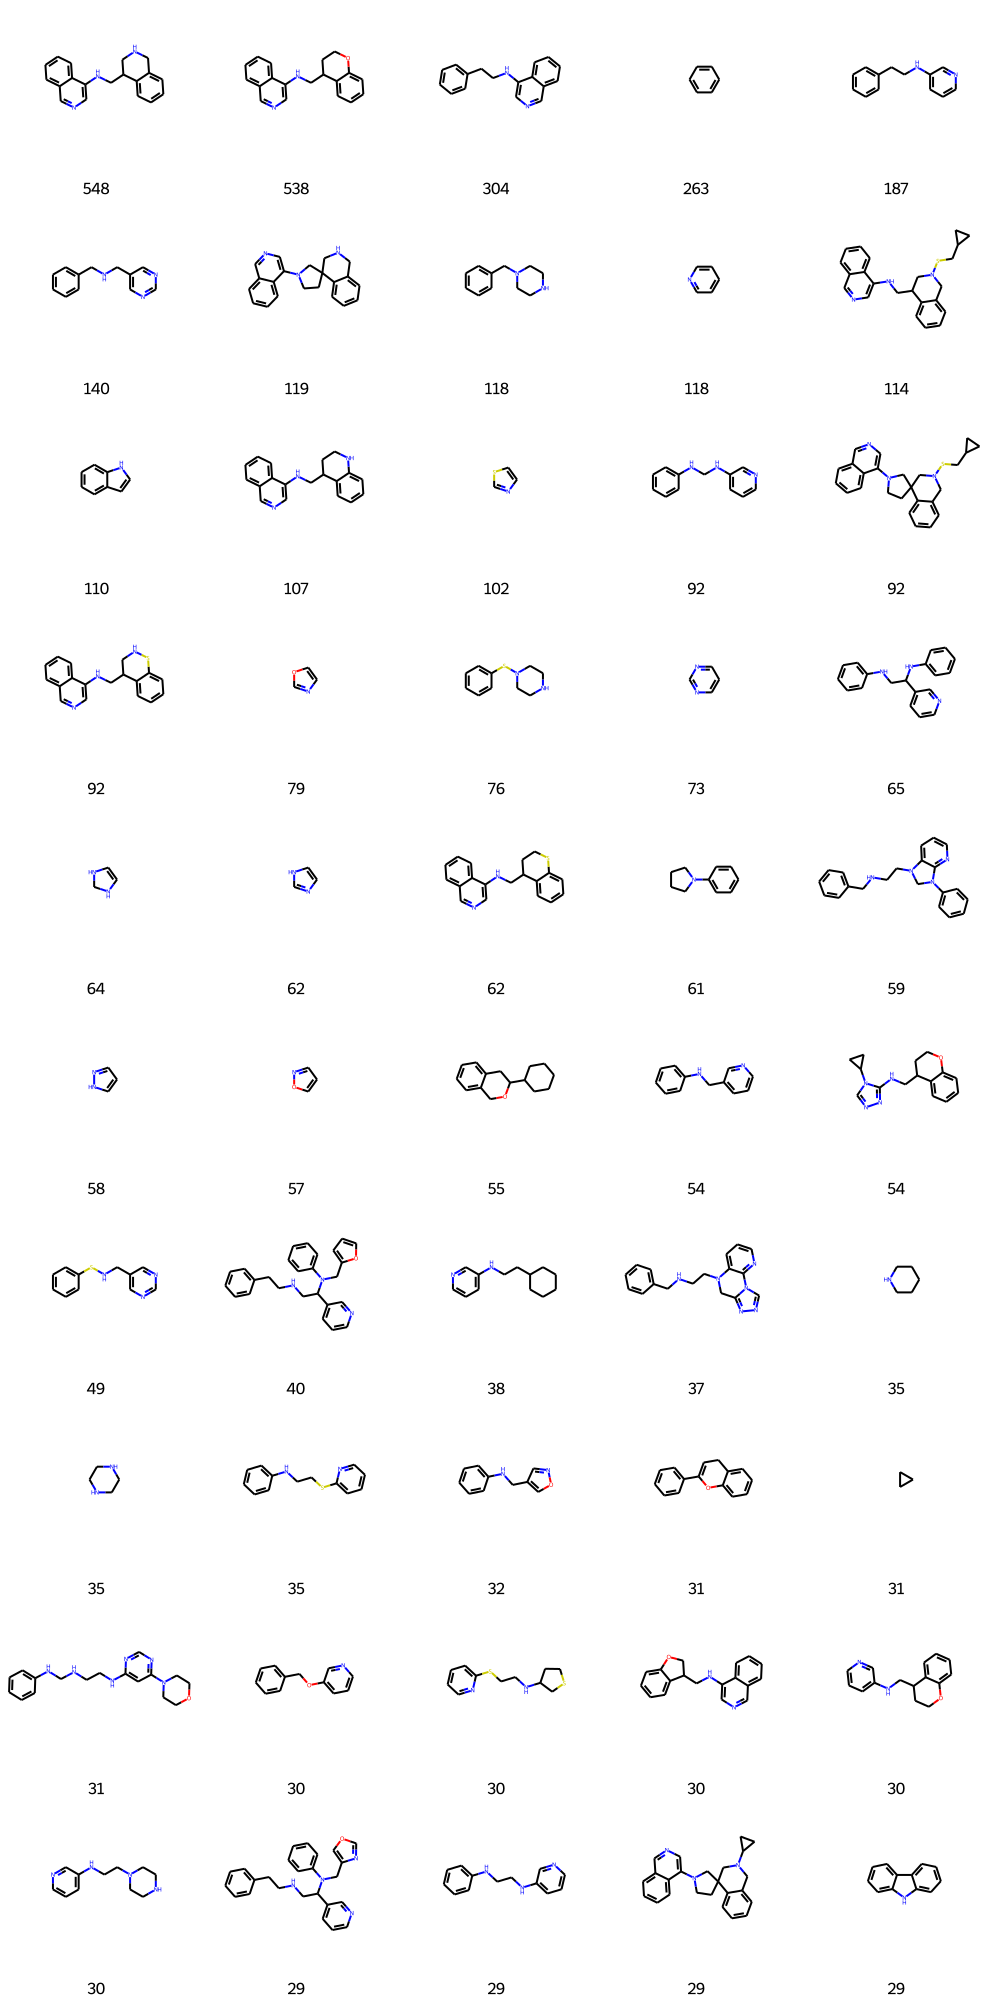

In [9]:
from rdkit.Chem import Draw

#Create dataframe of just scaffolds
#Select the 100 most common scaffolds
scaffolds = mol_df.groupby(['mHash']).size()
scaffolds_df = scaffolds.nlargest(100).to_frame(name="counts")

#Remove empty index row as this breaks everything
#There are 73 cases of empty scaffolds (no ring)
scaffolds_df.drop(labels="", inplace=True)

#Turn scaffold hash into a molecule for visualisation
scaffolds_df["scaffolds"] = scaffolds_df.apply(lambda x: Chem.MolFromSmiles(x.name), axis = 1)
#Create legend labels to show below molecule (this is the number of occuranced of the scaffold)
legends = [str(x) for x in list(scaffolds_df["counts"])]

#Visualise
Draw.MolsToGridImage(list(scaffolds_df["scaffolds"]),subImgSize=(200,200),molsPerRow=5,legends = legends)

# Considering the Generic Murcko Scaffold (without atom identity)

/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/nichrun/miniconda3/envs/data_driven_fep_rel/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


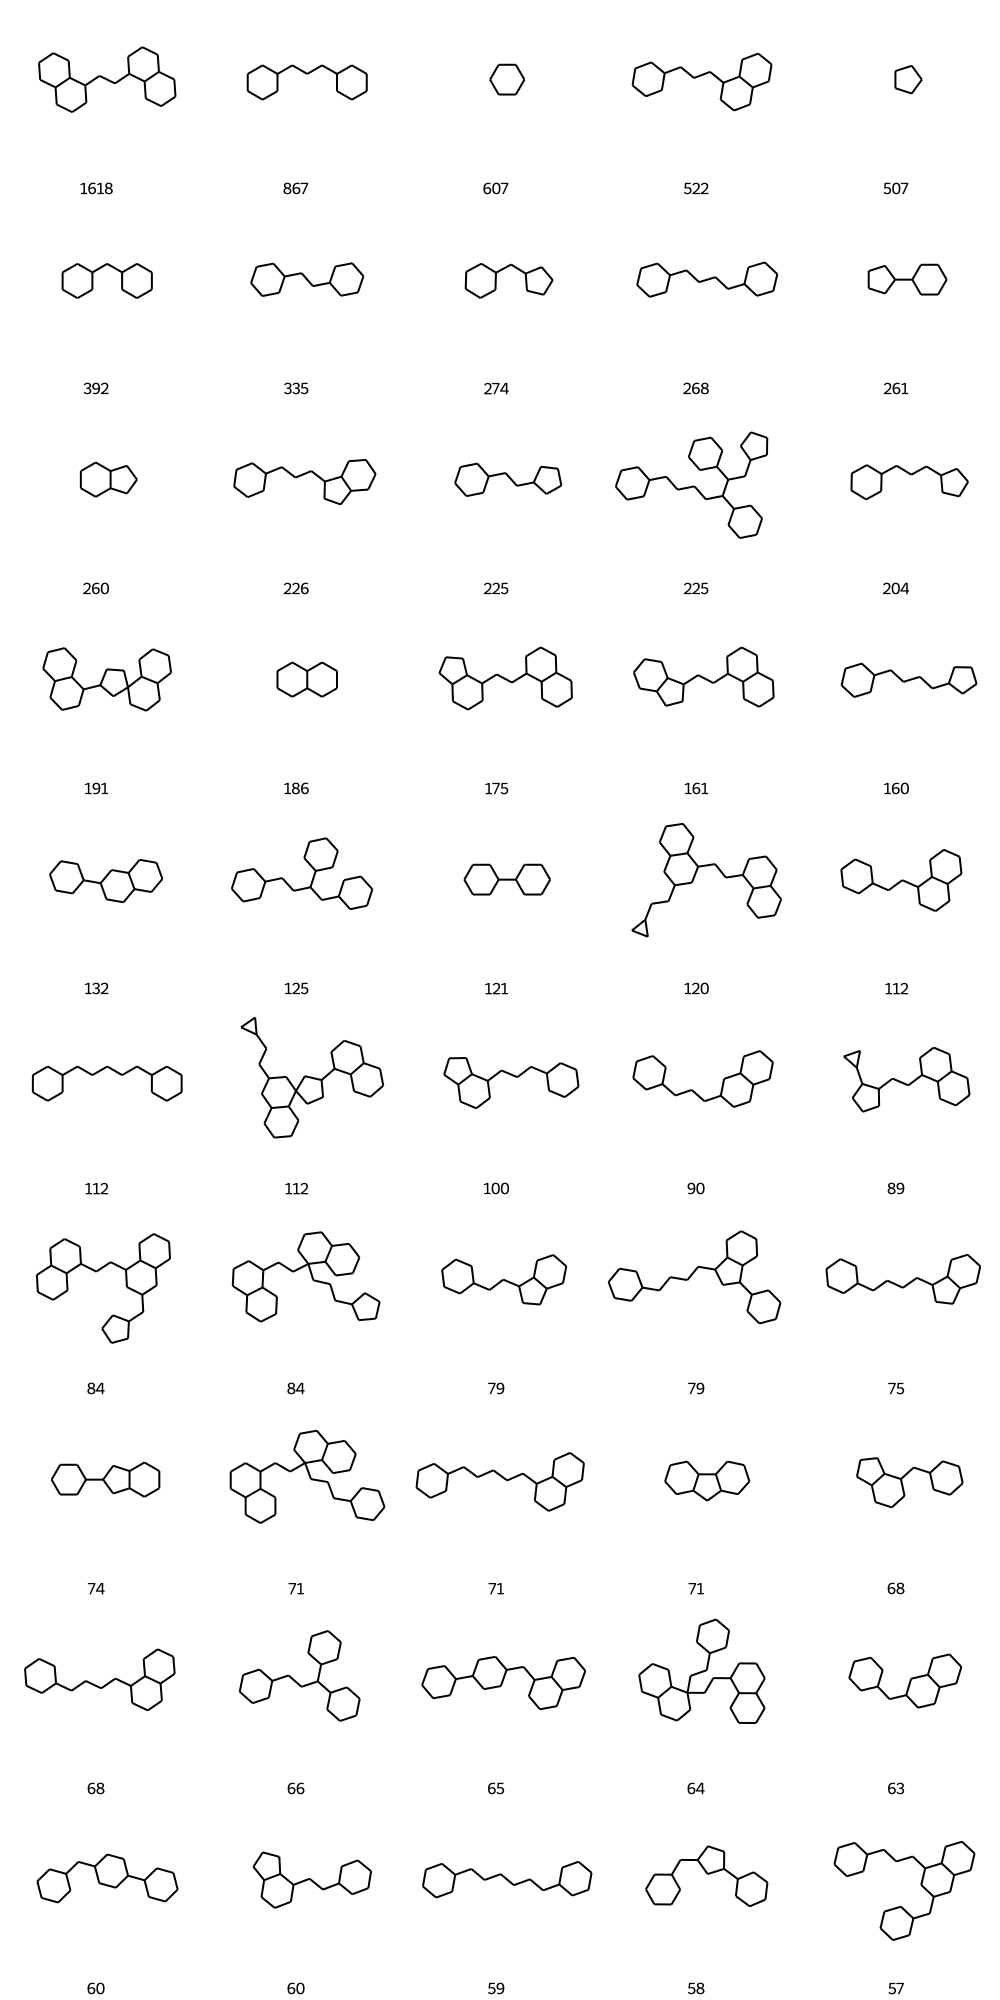

In [255]:
#Take hash of scaffold
mol_df["mHashGeneric"] = mol_df.apply(lambda x: rdMolHash.MolHash(x["TrueMurckoGeneric"], rdkit.Chem.rdMolHash.HashFunction.MurckoScaffold), axis = 1)

#Create dataframe of just scaffolds
#Select the 100 most common scaffolds
scaffolds = mol_df.groupby(['mHashGeneric']).size()
scaffolds_df = scaffolds.nlargest(100).to_frame(name="counts")

#Remove empty index row as this breaks everything
#There are 73 cases of empty scaffolds (no ring)
scaffolds_df.drop(labels="", inplace=True)

#Turn scaffold hash into a molecule for visualisation
scaffolds_df["scaffolds"] = scaffolds_df.apply(lambda x: Chem.MolFromSmiles(x.name), axis = 1)
#Create legend labels to show below molecule (this is the number of occuranced of the scaffold)
legends = [str(x) for x in list(scaffolds_df["counts"])]

#Visualise
Draw.MolsToGridImage(list(scaffolds_df["scaffolds"]),subImgSize=(200,200),molsPerRow=5,legends = legends)

In [267]:
"""
with open("largest_generic_scaffold.csv", "w") as writefile:
    for line in list(mol_df.loc[mol_df["mHashGeneric"]=="C1CCC2C(C1)CCCC2CCC1CCCC2CCCCC21"]["CID"]):
        writefile.write(line+"\n")
"""

'\nwith open("largest_generic_scaffold.csv", "w") as writefile:\n    for line in list(mol_df.loc[mol_df["mHashGeneric"]=="C1CCC2C(C1)CCCC2CCC1CCCC2CCCCC21"]["CID"]):\n        writefile.write(line+"\n")\n'

# Do interesting subsets already have docked structures? 

In [11]:
def MolFromName(name):
    """
    Function to find molecule in dataframe by CID
    input: (string) CID
    output: (object) mol
    """
    reference_row = df[df["CID"] == name]
    if len(reference_row) == 1:
        return Chem.MolFromSmiles(reference_row.iloc[0]["SMILES"])
    else:
        print("Name not found in df")
        return False

In [12]:
docked_name = []
with open("../../../molecules_with_poses.txt") as file:
    for line in ((file.readlines()[0]).split(", ")):
        docked_name.append(line.strip("'").strip("['").strip("']"))
docked_name_set = set(docked_name)

In [13]:
def GetSetWithSameScaffold(ref_mol,generic=False,display_result=False):
    ref_scaffold = GetTrueScaffold(ref_mol,generic=generic)
    ref_mol_hash = rdMolHash.MolHash(ref_scaffold, rdkit.Chem.rdMolHash.HashFunction.MurckoScaffold)
    
    if not generic:
        result = mol_df.loc[mol_df["mHash"]==ref_mol_hash]
    else:
        result = mol_df.loc[mol_df["mHashGeneric"]==ref_mol_hash]
        
    if display_result:
        print(f"size of subset: {len(result)}\ngeneric scaffold: {generic}\nmol hash: {ref_mol_hash}")
        print(f"Docked structures: {len(set.intersection(set(result['CID']), docked_name_set))}")
        
        display(Draw.MolsToGridImage(list(result["Molecule"]),subImgSize=(200,200),molsPerRow=5,legends=list(result["CID"])))

    return result

size of subset: 27
generic scaffold: False
mol hash: C1=C(CNCCOc2ccccc2)c2ccccc2NC1
Docked structures: 1


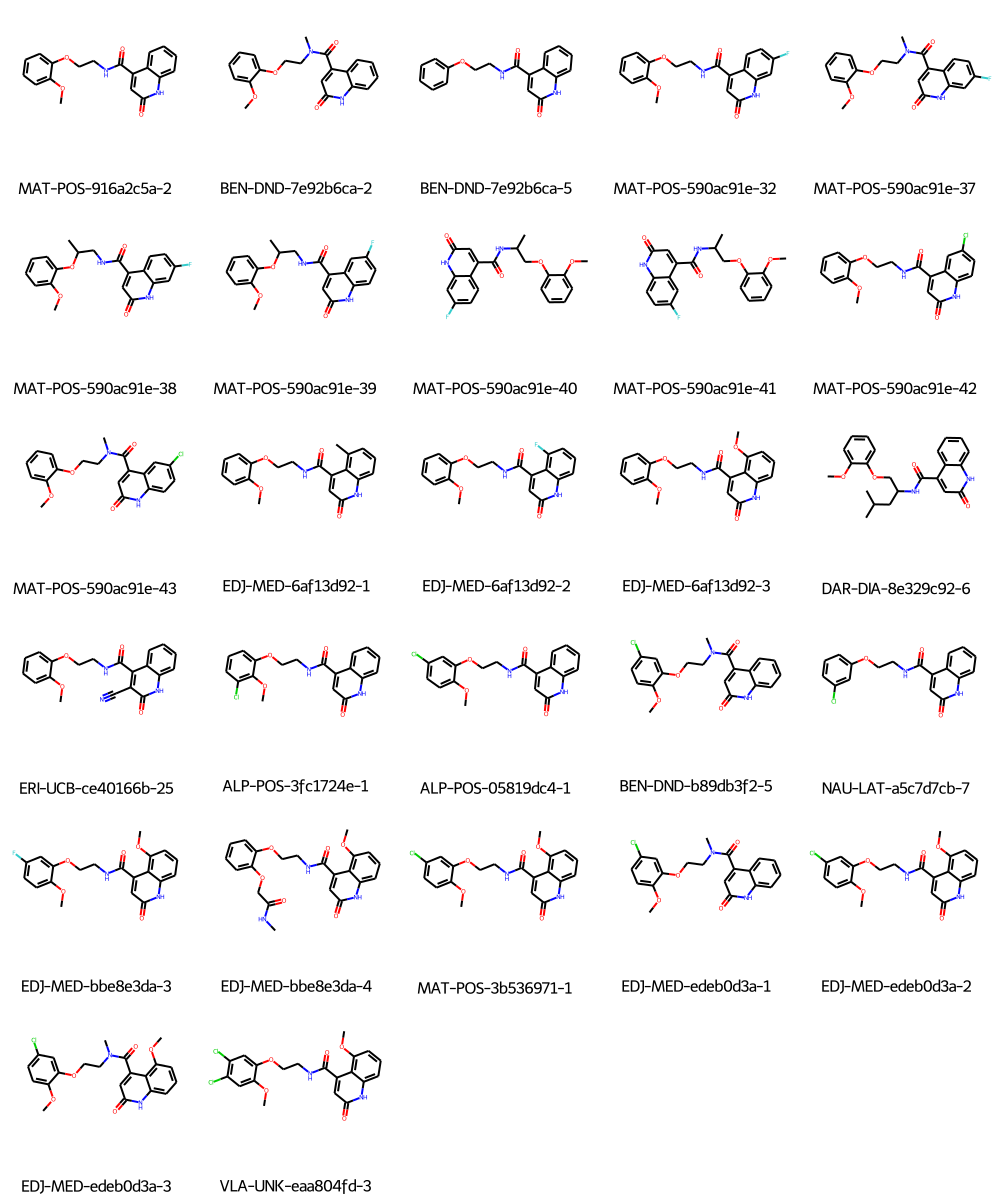

In [14]:
example_mol=MolFromName("MAT-POS-3b536971-1")
e = GetSetWithSameScaffold(example_mol,display_result=True)

In [15]:
"""
Aminopyridines - no docked structures
Ugis - 
Quinolones
Benzotriazoles
"""

Quinolones = [
"MAT-POS-3b536971-1",
"ERI-UCB-ce40166b-17",
"EDJ-MED-6af13d92-3",
"ERI-UCB-a0b0dbcb-2",
"EDJ-MED-bbe8e3da-2",
"ERI-UCB-a0b0dbcb-4",
"ALP-POS-ddb41b15-4"
]

main_series = [
    'TRY-UNI-714a760b-6',
    'ADA-UCB-6c2cb422-1',
    'MAT-POS-b3e365b9-1',
    'MAT-POS-3ccb8ef6-1',
    'MAT-POS-24589f88-3',
    'MAT-POS-e194df51-1']

In [16]:
def SameScaffoldDock(ref_mol, generic=False):
    r = GetSetWithSameScaffold(ref_mol, generic=generic)
    set1 = (r["CID"])
    
    return set.intersection(docked_name_set, set1)

In [17]:
print("Reference mol name\tScaff \tDocked")
for name in main_series:
    ref_mol=MolFromName(name)
    print(name,"\t",len(GetSetWithSameScaffold(ref_mol, generic=True)),"\t",len(SameScaffoldDock(ref_mol, generic=True)))

Reference mol name	Scaff 	Docked
TRY-UNI-714a760b-6 	 867 	 256
ADA-UCB-6c2cb422-1 	 522 	 29
MAT-POS-b3e365b9-1 	 1618 	 0
MAT-POS-3ccb8ef6-1 	 1618 	 0
MAT-POS-24589f88-3 	 1618 	 0
MAT-POS-e194df51-1 	 120 	 0


In [18]:
"""
ROB-UNI-b2e39629-7   85
TRY-UNI-714a760b-6   256
ROB-UNI-b2e39629-6 118
"""

'\nROB-UNI-b2e39629-7   85\nTRY-UNI-714a760b-6   256\nROB-UNI-b2e39629-6 118\n'

In [19]:
#GetSetWithSameScaffold(MolFromName("ROB-UNI-b2e39629-6"),display_result=True, generic=True)

In [21]:
#Count docked structures with each scaffold
"""
scaffolds_df["docked"] = 

for i in range(len(scaffolds_df)):
    display(scaffolds_df.iloc[i]["scaffolds"])
    print(len(SameScaffoldDock(scaffolds_df.iloc[i]["scaffolds"], generic=True)))
"""

'\nscaffolds_df["docked"] = \n\nfor i in range(len(scaffolds_df)):\n    display(scaffolds_df.iloc[i]["scaffolds"])\n    print(len(SameScaffoldDock(scaffolds_df.iloc[i]["scaffolds"], generic=True)))\n'

In [94]:
scaffolds = mol_df.groupby(['mHash']).size()
scaffolds_df = scaffolds.nlargest(1000).to_frame(name="counts")

scaffolds_df.drop(labels="", inplace=True)

scaffolds_df["scaffolds"] = scaffolds_df.apply(lambda x: Chem.MolFromSmiles(x.name), axis = 1)


scaffolds_df["docked"] = scaffolds_df.apply(lambda x: SameScaffoldDock(x.scaffolds, generic=False), axis = 1)
scaffolds_df["dockedNum"] = scaffolds_df.apply(lambda x: len(SameScaffoldDock(x.scaffolds, generic=False)), axis = 1)

In [97]:
scaffolds_df.nlargest(30,columns="dockedNum")[["docked"]]

AttributeError: module 'pandas.io.formats.format' has no attribute '_get_adjustment'

                                                                                            docked
mHash                                                                                             
c1ccccc1                                         {NEL-UNI-1464a899-5, MAK-UNK-194150d3-3, MAK-U...
c1ccc2[nH]ccc2c1                                 {DAR-DIA-eace69ff-35, MAR-UNI-9ca61fdc-1, ANT-...
c1ccc(NCNc2cccnc2)cc1                            {ANN-UNI-26382800-3, JAN-LUN-8953ce76-1, DAR-D...
c1ccc(CN2CCNCC2)cc1                              {ANT-OPE-d972fbad-1, TAM-UNI-d1c3dd9f-4, PAU-U...
c1ccc2c(c1)COC(C1CCCCC1)C2                       {MAK-UNK-2084232d-17, MAK-UNK-198e6d85-13, MAK...
c1ccc(CCNc2cccnc2)cc1                            {AGN-NEW-c7b24fe3-2, AGN-NEW-cce853d0-2, AGN-N...
c1ccc(NCC(Nc2ccccc2)c2cccnc2)cc1                 {LON-WEI-b8d98729-45, LON-WEI-b8d98729-33, LON...
c1ccncc1                                         {MAR-UNI-9d4da90d-2, ANT-DIA-b7f58f21-1, MAK-U...
c1ccc(NCc2

In [95]:
for sets in list(scaffolds_df["docked"]):
    if len(sets) > 0:
        display(len(sets))

102

46

59

39

85

2

66

2

20

40

3

55

38

32

18

18

1

3

2

16

1

1

21

1

26

8

16

1

3

5

20

11

16

2

5

8

19

6

1

4

3

12

17

5

10

17

1

7

1

14

15

8

14

2

14

12

13

2

10

4

13

8

12

2

6

1

11

12

1

5

10

2

8

1

6

10

4

10

10

2

10

9

2

9

9

4

8

8

3

9

3

9

2

8

4

8

8

8

2

5

1

3

3

5

1

7

1

1

7

3

1

2

1

1

4

1

6

6

1

5

6

4

6

6

6

1

3

3

2

3

6

6

6

6

4

6

6

4

2

6

6

3

6

2

6

6

4

2

3

5

1

1

5

4

4

2

2

1

5

4

5

5

2

5

5

3

2

2

5

3

5

5

2

4

5

2

3

4

4

3

4

4

2

3

4

4

4

4

4

4

1

4

4

4

4

4

4

4

4

4

2

4

4

4

3

4

1

4

4

1

3

4

4

4

4

4

4

1

2

4

4

4

4

4

4

1

3

4

4

4

4

4

4

3

4

4

4

4

1

4

4

2

4

1

3

3

3

3

3

1

3

3

2

3

1

1

3

3

2

3

3

3

3

3

3

3

3

1

3

2

3

3

3

3

3

3

1

3

3

2

3

1

1

3

3

3

3

3

1

3

1

3

1

3

2

3

1

2

2

3

3

2

2

1

3

3

3

3

3

3

3

3

2

3

3

3

3

3

3

3

3

3

3

3

In [72]:
out = (scaffolds_df.nlargest(30,columns="dockedNum")[["docked"]])

In [78]:
master_list = []
for sets in list(out["docked"]):
    sets = list(sets)
    master_list += sets

In [82]:
"""
file_name = "largest_scaffold_set_with_dock_single.csv"
with open(file_name,"w") as writefile:
    for line in master_list:
        writefile.write(line+"\n")
""" 

In [93]:
docked_ligand_series = list(SameScaffoldDock(MolFromName("DAN-LON-a5fc619e-3"), generic=False))

In [98]:
dock_and_activity = ['DAR-DIA-23aa0b97-8', 'DAR-DIA-23aa0b97-11', 'DAR-DIA-23aa0b97-19', 'DAR-DIA-23aa0b97-20', 'WAR-XCH-eb7b662f-2', 'TRY-UNI-714a760b-3', 'TRY-UNI-714a760b-6', 'TRY-UNI-714a760b-12', 'TRY-UNI-714a760b-18', 'TRY-UNI-714a760b-19', 'TRY-UNI-714a760b-20', 'TRY-UNI-714a760b-22', 'TRY-UNI-714a760b-24', 'JOR-UNI-2fc98d0b-12', 'AGN-NEW-891393a6-1', 'DUN-NEW-f8ce3686-22', 'DUN-NEW-f8ce3686-23', 'DUN-NEW-f8ce3686-24', 'CHR-SOS-7098f804-10', 'CHR-SOS-7098f804-14', 'JOH-MSK-a63bdd1d-4', 'DAN-LON-a5fc619e-3', 'DAN-LON-a5fc619e-8', 'NIR-THE-c331be7a-1', 'NIR-THE-c331be7a-2', 'NIR-THE-c331be7a-6', 'NIR-THE-0d6461ce-8', 'GIA-UNK-a79af1bc-1', 'RUT-UNI-630c5802-20', 'DAV-CRI-3edb475e-4', 'DAV-CRI-3edb475e-6', 'DAV-CRI-14a23e73-1', 'GAB-REV-70cc3ca5-8', 'BAR-COM-4e090d3a-6', 'DAR-DIA-fb20be43-4', 'DAR-DIA-fb20be43-6', 'DAR-DIA-fb20be43-7', 'BRU-LEF-ae0885ba-1', 'GIA-UNK-20b63697-2', 'GIA-UNK-20b63697-6', 'MAK-UNK-af83ef51-2', 'MAK-UNK-af83ef51-6', 'TAM-UNI-d1c3dd9f-5', 'PAU-UNI-8cdd41c7-1', 'PAU-UNI-52c0427f-1', 'STU-CHA-6cae54d3-1', 'STU-CHA-7b3b91d5-1', 'STU-CHA-83dacf15-1', 'SIM-SYN-f15aaa3a-1', 'WAR-XCH-b0339bbe-19', 'WAR-XCH-79d12f6e-4', 'WAR-XCH-79d12f6e-6', 'MIH-UNI-e573136b-5', 'NEH-REV-107bcf72-5', 'JUA-UNI-bc099708-1', 'JUA-UNI-bc099708-2', 'JUA-UNI-bc099708-3', 'JUA-UNI-bc099708-4', 'JUA-UNI-bc099708-5', 'MAT-POS-916a2c5a-1', 'MAT-POS-916a2c5a-2', 'MAT-POS-916a2c5a-3', 'MAT-POS-916a2c5a-4', 'LON-WEI-b8d98729-15', 'LON-WEI-b8d98729-17', 'LON-WEI-b8d98729-23', 'LON-WEI-b8d98729-27', 'LON-WEI-b8d98729-38', 'LON-WEI-b8d98729-39', 'MED-COV-4280ac29-12', 'MED-COV-4280ac29-13', 'MED-COV-4280ac29-15', 'MED-COV-4280ac29-25', 'MED-COV-4280ac29-30', 'MED-COV-4280ac29-31', 'MED-COV-4280ac29-33', 'MED-COV-4280ac29-37', 'LON-WEI-8f408cad-1', 'LON-WEI-8f408cad-2', 'LON-WEI-8f408cad-3', 'LON-WEI-8f408cad-4', 'LON-WEI-8f408cad-5', 'LON-WEI-8f408cad-7', 'LON-WEI-8f408cad-8', 'JUA-UNI-a9dfaed1-1', 'JUA-UNI-a9dfaed1-2', 'JUA-UNI-a9dfaed1-3', 'JUA-UNI-a9dfaed1-4', 'JUA-UNI-a9dfaed1-5', 'JUA-UNI-a9dfaed1-6', 'JUA-UNI-a9dfaed1-7', 'LON-WEI-adc59df6-3', 'LON-WEI-adc59df6-10', 'LON-WEI-adc59df6-17', 'LON-WEI-adc59df6-23', 'LON-WEI-adc59df6-26', 'LON-WEI-adc59df6-28', 'LON-WEI-adc59df6-30', 'LON-WEI-adc59df6-32', 'LON-WEI-adc59df6-40', 'LON-WEI-adc59df6-43', 'LON-WEI-adc59df6-45', 'LON-WEI-adc59df6-47', 'LON-WEI-adc59df6-53', 'AAR-POS-8a4e0f60-7']


In [100]:
len(dock_and_activity)

105

In [180]:
def SameScaffoldDockActivity(ref_mol, generic=False):
    r = GetSetWithSameScaffold(ref_mol, generic=generic)
    set1 = (r["CID"])
    set2 = set(dock_and_activity)
    return set.intersection(set2, set1)

In [251]:
generic = False

if generic:
    scaffolds = mol_df.loc[mol_df["CID"].isin(dock_and_activity)].groupby(['mHashGeneric']).size()
else:
    scaffolds = mol_df.loc[mol_df["CID"].isin(dock_and_activity)].groupby(['mHash']).size()
scaffolds_df = scaffolds.nlargest(1000).to_frame(name="counts")

scaffolds_df["scaffolds"] = scaffolds_df.apply(lambda x: Chem.MolFromSmiles(x.name), axis = 1)

scaffolds_df["docked"] = scaffolds_df.apply(lambda x: SameScaffoldDockActivity(x.scaffolds, generic=generic), axis = 1)
scaffolds_df["dockedNum"] = scaffolds_df.apply(lambda x: len(SameScaffoldDockActivity(x.scaffolds, generic=generic)), axis = 1)

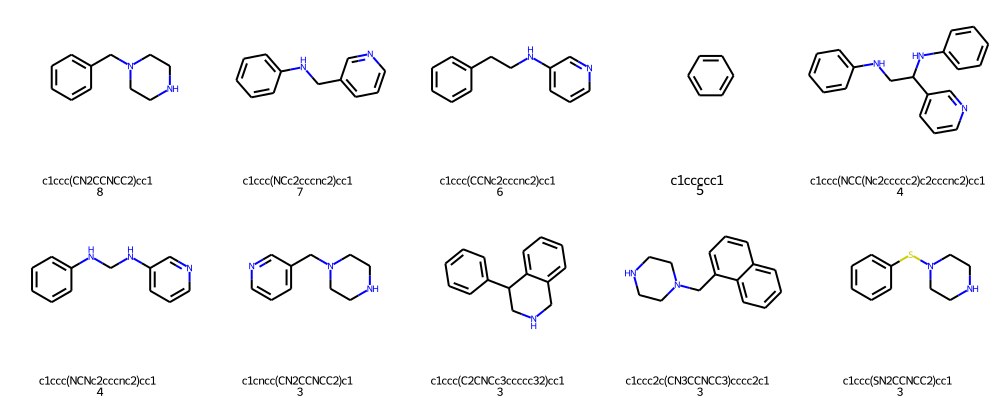

In [252]:
#list(scaffolds_df["dockedNum"])
scaffolds_df = scaffolds_df.loc[scaffolds_df["dockedNum"]>2]
scaffolds_df = scaffolds_df.nlargest(1000,columns="dockedNum")

legends = [(x+"\n"+str(y)) for x,y in zip(list(scaffolds_df.index),(scaffolds_df["dockedNum"]))]

display(Draw.MolsToGridImage(list(scaffolds_df["scaffolds"]),subImgSize=(200,200),molsPerRow=5,maxMols=100,legends=legends))

'##########    Number of molecules in set: 8    generic murcko scaffold: False  ###########'

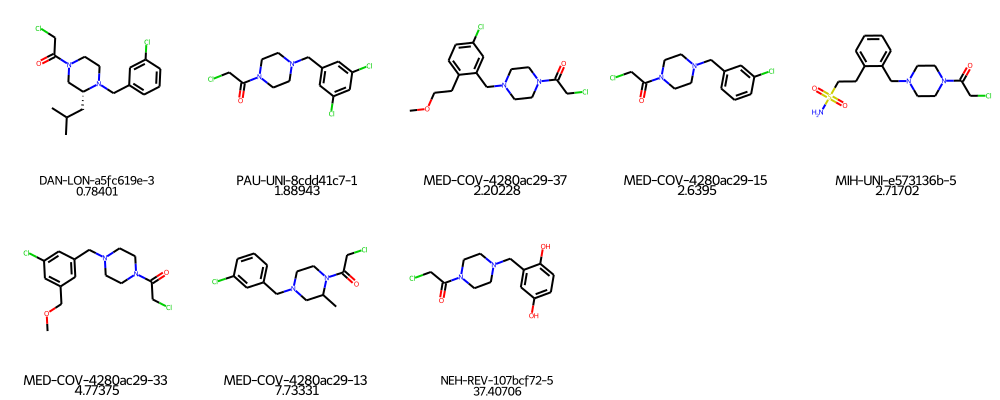

'##########    Number of molecules in set: 7    generic murcko scaffold: False  ###########'

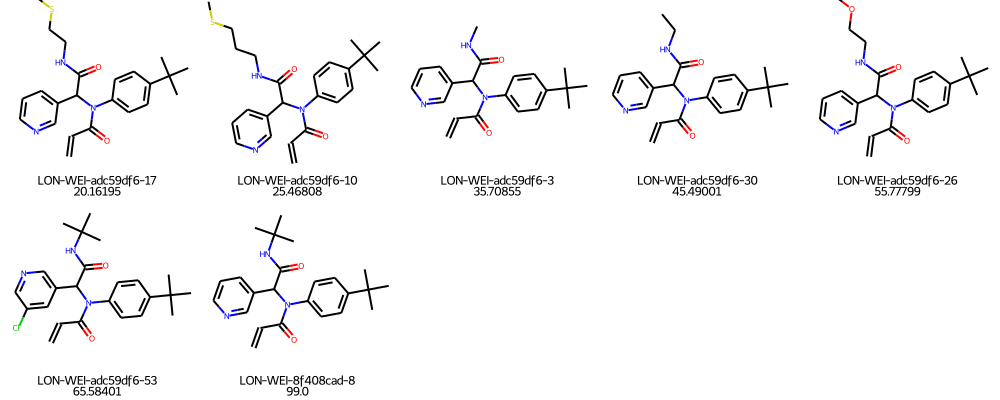

'##########    Number of molecules in set: 6    generic murcko scaffold: False  ###########'

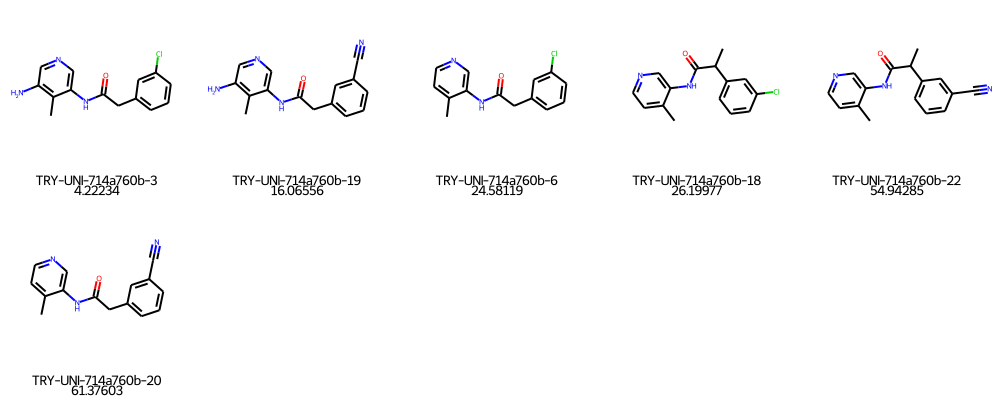

'##########    Number of molecules in set: 5    generic murcko scaffold: False  ###########'

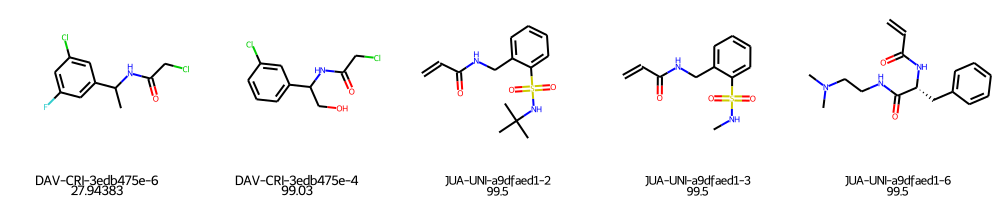

'##########    Number of molecules in set: 4    generic murcko scaffold: False  ###########'

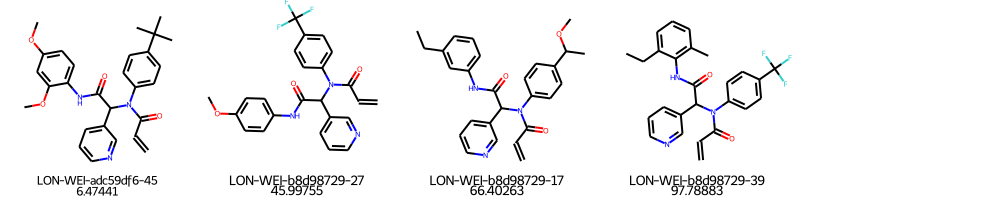

'##########    Number of molecules in set: 4    generic murcko scaffold: False  ###########'

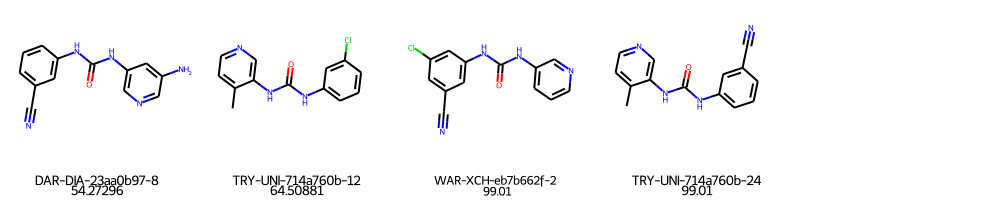

'##########    Number of molecules in set: 3    generic murcko scaffold: False  ###########'

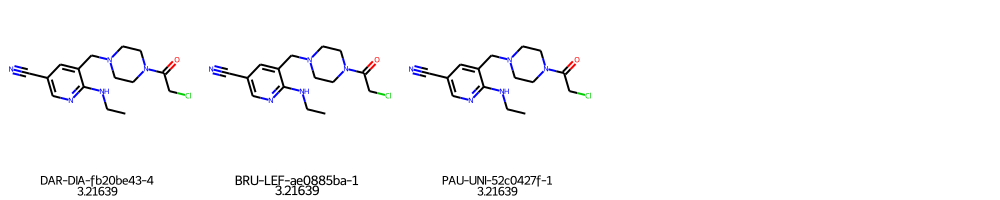

'##########    Number of molecules in set: 3    generic murcko scaffold: False  ###########'

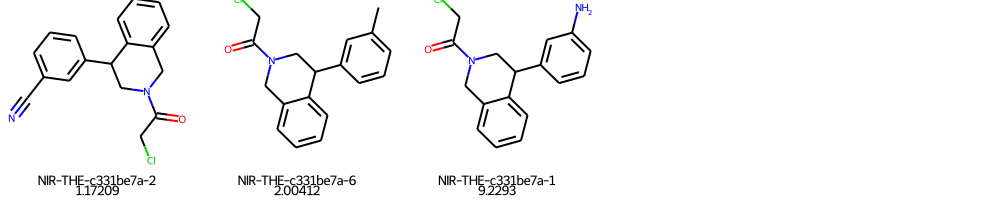

'##########    Number of molecules in set: 3    generic murcko scaffold: False  ###########'

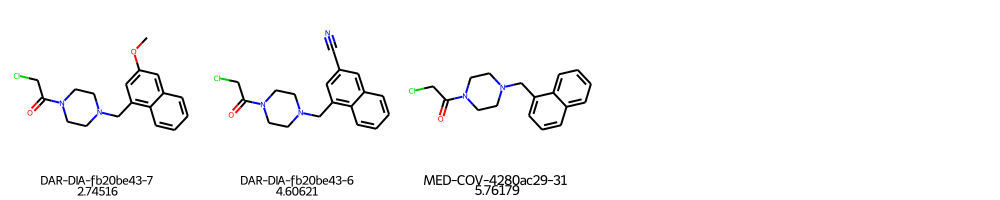

'##########    Number of molecules in set: 3    generic murcko scaffold: False  ###########'

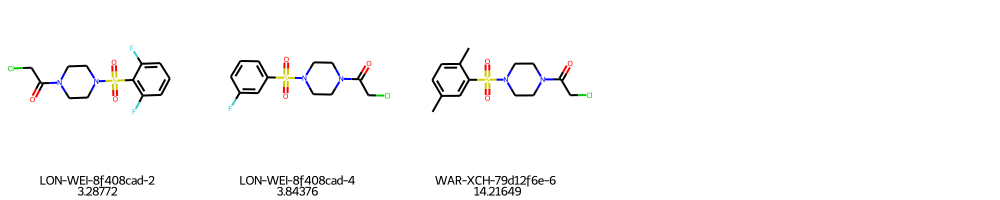

In [253]:
for i in range(len(scaffolds_df)):
    

    res = scaffolds_df.iloc[i]
    res = list(res["docked"])
    mols_to_show = df.loc[df["CID"].isin(res)]
    mols_to_show = mols_to_show.nsmallest(1000, columns="f_avg_IC50")
    
    display(f"##########    Number of molecules in set: {len(mols_to_show)}    generic murcko scaffold: {generic}  ###########")

    legends = [x+"\n"+str(round(y,5)) for x,y in zip(list(mols_to_show["CID"]),list(mols_to_show["f_avg_IC50"]))]
    display(Draw.MolsToGridImage(list(mols_to_show["Molecule"]),subImgSize=(200,200),molsPerRow=5,maxMols=100,legends=legends))

In [254]:
list(scaffolds_df.iloc[0]["docked"])

['NEH-REV-107bcf72-5',
 'PAU-UNI-8cdd41c7-1',
 'MED-COV-4280ac29-13',
 'MED-COV-4280ac29-33',
 'MIH-UNI-e573136b-5',
 'DAN-LON-a5fc619e-3',
 'MED-COV-4280ac29-15',
 'MED-COV-4280ac29-37']